### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

This model averages across ALL of the embeddings (CLS and the embedded padded 0's included). 85% acc

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-19 18:05:38.241052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-19 18:05:38.241167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorc

Changes from previous version: I am implementing COVID-19 classification with ProtTrans (Rostlab models) starting with the BFD

In [3]:
def get_embeddings(sequence_list):
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding='max_length', max_length=140, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids, attention_mask=attention_mask)[0])
    averaged_embeddings = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        residues = embedding[seq_num]
        #[1:seq_len-1]
        average = np.mean(residues, axis=0)

        averaged_embeddings.append(average)

    return np.asarray(averaged_embeddings)

In [4]:
sequences_Example = ["A E T C X A X","S K T X P"] # REMEMBER SPACING

In [5]:
averaged_embeddings = get_embeddings(sequences_Example)

In [6]:
# ids = tokenizer.batch_encode_plus(sequences_Example, add_special_tokens=True, padding=True, return_tensors="tf")
# embeddings = embedding_model.bert(ids['input_ids'], attention_mask=ids['attention_mask'])
# embeddings

In [7]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [8]:
tf.__version__

'2.10.0'

# Data Formatting

In [9]:
df = pd.read_csv("../Data/CoV-AbDab_201222.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
0,EVQLVESGGGLIQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLE...
1,EVQLVQSGGGLVQPGGSLRLSCLASGLTFSSYEFNWIRQAPGKGLE...
2,QVQLVQSGAEVKRPGASVKVLCMASGYSFTNYGINWVRQAPGQGLE...
3,EVQLVQSGAEVKKPRESLKISCKGSGYNFTSYWIGWVRQMPGKGLE...
4,EVQLVESGGGLVQPGGSLRLSCAASRFTFANYWMSWVRQAPGKGLE...
...,...
11999,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
12000,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
12001,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
12002,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [10]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11538:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11538


In [11]:
del head
del myfile
del dummy
gc.collect()

0

In [12]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [13]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [14]:
if os.path.exists('prot_bert_bfd_v4_embeddings') == False:
    os.mkdir('prot_bert_bfd_v4_embeddings')

In [15]:
print(round(len(covid_sequences) * 0.9999999))
print(round(len(covid_sequences) * 0.6666666))
print(round(len(covid_sequences) * 0.3333333))

11538
7692
3846


In [16]:
covid_sequences_1 = [(" ".join(s)) for s in covid_sequences][:round(len(covid_sequences) * 0.3)]
covid_sequences_2 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.3):round(len(covid_sequences) * 0.6)]
covid_sequences_3 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.6):round(len(covid_sequences) * 0.9)]
covid_sequences_4 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.9):]

In [17]:
covid_averaged_embeddings_1 = get_embeddings(covid_sequences_1)

In [18]:
with open("prot_bert_bfd_v4_embeddings/covid_1.pkl", "wb") as f:
    pickle.dump(covid_averaged_embeddings_1, f)

del covid_sequences_1
del covid_averaged_embeddings_1
gc.collect()

0

In [19]:
covid_averaged_embeddings_2 = get_embeddings(covid_sequences_2)

In [20]:
with open("prot_bert_bfd_v4_embeddings/covid_2.pkl", "wb") as f:
    pickle.dump(covid_averaged_embeddings_2, f)

del covid_sequences_2
del covid_averaged_embeddings_2
gc.collect()

0

In [21]:
covid_averaged_embeddings_3 = get_embeddings(covid_sequences_3)

In [22]:
with open("prot_bert_bfd_v4_embeddings/covid_3.pkl", "wb") as f:
    pickle.dump(covid_averaged_embeddings_3, f)

del covid_sequences_3
del covid_averaged_embeddings_3
gc.collect()

0

In [23]:
covid_averaged_embeddings_4 = get_embeddings(covid_sequences_4)

In [24]:
with open("prot_bert_bfd_v4_embeddings/covid_4.pkl", "wb") as f:
    pickle.dump(covid_averaged_embeddings_4, f)

del covid_sequences_4
del covid_averaged_embeddings_4
gc.collect()

0

In [25]:
healthy_sequences_1 = [(" ".join(s)) for s in healthy_sequences][:round(len(healthy_sequences) * 0.3)]
healthy_sequences_2 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.3):round(len(healthy_sequences) * 0.6)]
healthy_sequences_3 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.6):round(len(healthy_sequences) * 0.9)]
healthy_sequences_4 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.9):]

In [26]:
healthy_averaged_embeddings_1 = get_embeddings(healthy_sequences_1)

In [27]:
with open("prot_bert_bfd_v4_embeddings/healthy_1.pkl", "wb") as f:
    pickle.dump(healthy_averaged_embeddings_1, f)

del healthy_sequences_1
del healthy_averaged_embeddings_1
gc.collect()

0

In [28]:
healthy_averaged_embeddings_2 = get_embeddings(healthy_sequences_2)

In [29]:
with open("prot_bert_bfd_v4_embeddings/healthy_2.pkl", "wb") as f:
    pickle.dump(healthy_averaged_embeddings_2, f)

del healthy_sequences_2
del healthy_averaged_embeddings_2
gc.collect()

0

In [30]:
healthy_averaged_embeddings_3 = get_embeddings(healthy_sequences_3)

In [31]:
with open("prot_bert_bfd_v4_embeddings/healthy_3.pkl", "wb") as f:
    pickle.dump(healthy_averaged_embeddings_3, f)

del healthy_sequences_3
del healthy_averaged_embeddings_3
gc.collect()

0

In [32]:
healthy_averaged_embeddings_4 = get_embeddings(healthy_sequences_4)

In [33]:
with open("prot_bert_bfd_v4_embeddings/healthy_4.pkl", "wb") as f:
    pickle.dump(healthy_averaged_embeddings_4, f)

del healthy_sequences_4
del healthy_averaged_embeddings_4
gc.collect()

0

# Loading

In [2]:
covid_averaged_embeddings = [[None] * 1024]

In [3]:
for i in range(1, 5):
    with open("prot_bert_bfd_v4_embeddings/covid_" + str(i) + ".pkl", "rb") as f:
        covid_temp = pickle.load(f)
        covid_averaged_embeddings = np.concatenate((covid_averaged_embeddings, covid_temp))
    f.close()

covid_averaged_embeddings = np.delete(covid_averaged_embeddings, 0, 0)

In [4]:
print(np.shape(covid_averaged_embeddings))

(11538, 1024)


In [5]:
healthy_averaged_embeddings = [[None] * 1024]

In [6]:
for i in range(1, 5):

    with open("prot_bert_bfd_v4_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_averaged_embeddings = np.concatenate((healthy_averaged_embeddings, healthy_temp))
    f.close()

healthy_averaged_embeddings = np.delete(healthy_averaged_embeddings, 0, 0)

In [7]:
print(healthy_averaged_embeddings.shape)

(11538, 1024)


In [8]:
healthy_lables = [0] * 11538
covid_lables = [1] * 11538

# Model 2: Pooled Embeddings

In [9]:
X = np.concatenate((healthy_averaged_embeddings, covid_averaged_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [10]:
del healthy_averaged_embeddings
del covid_averaged_embeddings
gc.collect()

0

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [12]:
del X
del y
gc.collect()

0

In [13]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                        

2023-01-19 19:46:29.196111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-19 19:46:29.196255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [16]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    mode='auto',
    restore_best_weights=True,
)

In [17]:
history = model.fit(X_train, y_train, epochs=500, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/500


2023-01-19 19:46:30.299791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-19 19:46:30.647264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.7531

2023-01-19 19:46:37.359246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 7s 12ms/step - loss: 0.4791 - accuracy: 0.7531 - val_loss: 0.4480 - val_accuracy: 0.7703
Epoch 2/500
585/585 [==============================] - 7s 11ms/step - loss: 0.4230 - accuracy: 0.7905 - val_loss: 0.4130 - val_accuracy: 0.7843
Epoch 3/500
585/585 [==============================] - 7s 11ms/step - loss: 0.4007 - accuracy: 0.8027 - val_loss: 0.4063 - val_accuracy: 0.8040
Epoch 4/500
585/585 [==============================] - 7s 11ms/step - loss: 0.3915 - accuracy: 0.8089 - val_loss: 0.3890 - val_accuracy: 0.8175
Epoch 5/500
585/585 [==============================] - 7s 12ms/step - loss: 0.3792 - accuracy: 0.8153 - val_loss: 0.3881 - val_accuracy: 0.8175
Epoch 6/500
585/585 [==============================] - 7s 11ms/step - loss: 0.3755 - accuracy: 0.8165 - val_loss: 0.3929 - val_accuracy: 0.8016
Epoch 7/500
585/585 [==============================] - 7s 11ms/step - loss: 0.3662 - accuracy: 0.8219 - val_loss: 0.3639 - val_accuracy: 0.8238
Epoc

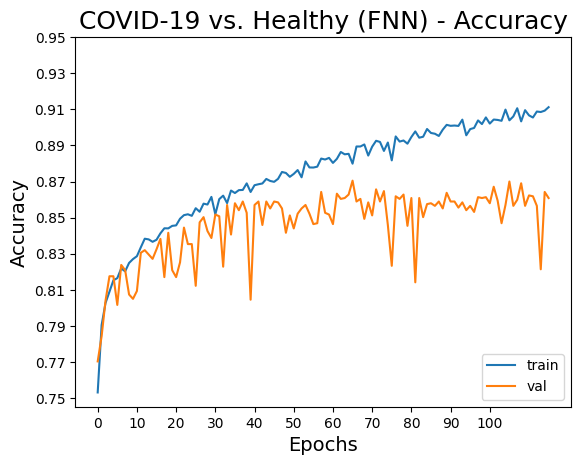

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('COVID-19 vs. Healthy (FNN) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 0.96, 0.02))
plt.xticks(np.arange(0, 108, 10.0)) # this upper bound subject to change
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 2 Testing

In [ ]:
model.save("prot_berd_bfd_v4.h5")

In [19]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 0s 5ms/step - loss: 0.3866 - accuracy: 0.8518


[0.38661864399909973, 0.8518197536468506]

In [ ]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 15ms/step


2023-01-11 10:12:21.106757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 18ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

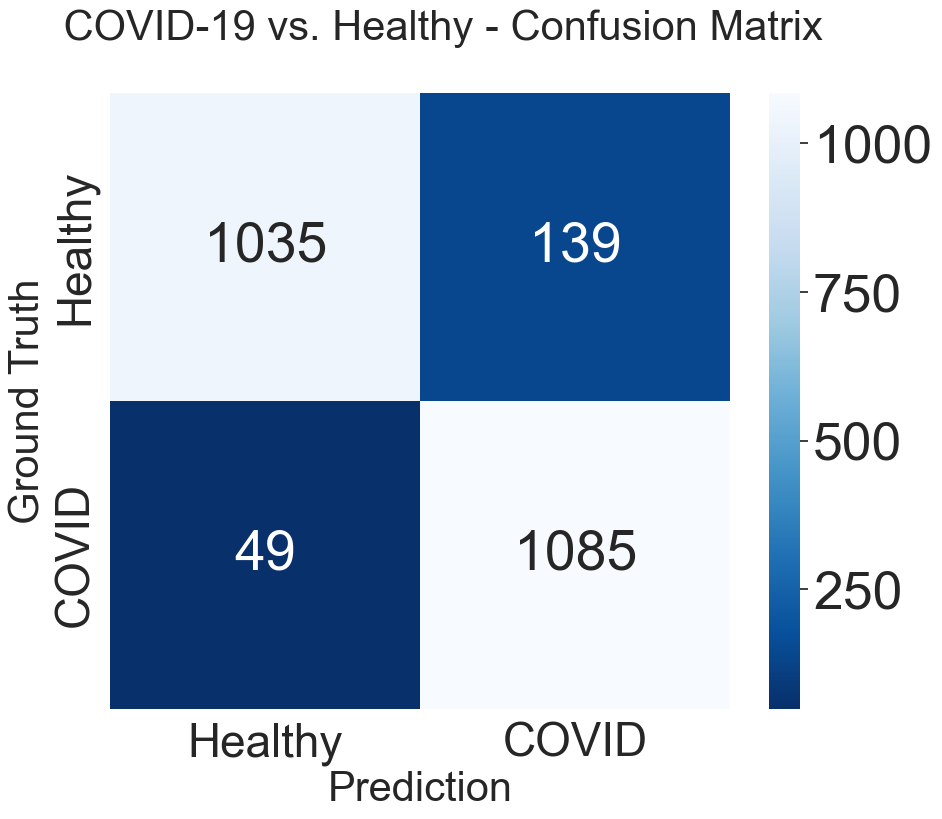

tf.Tensor(
[[1035  139]
 [  49 1085]], shape=(2, 2), dtype=int32)


In [ ]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    COVID-19 vs. Healthy - Confusion Matrix\n', fontsize=30)
sns.set(font_scale=3.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [ ]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

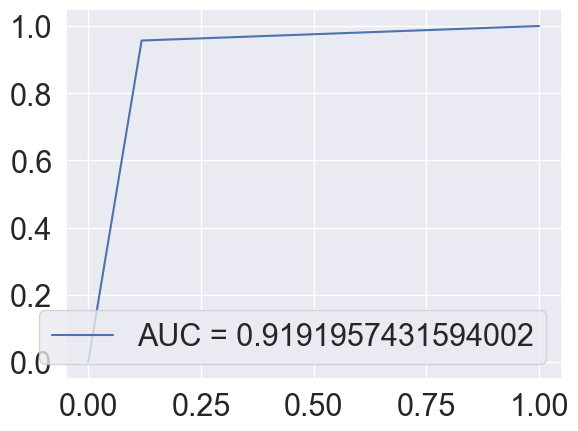

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()